<a href="https://colab.research.google.com/github/alexchez100/MSU_AI_22-23/blob/main/EX04_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q gdown
!pip install -q umap-learn
!pip install -q --upgrade git+https://github.com/MedMNIST/MedMNIST.git
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX04/dataset_without_pytorch.py

  Preparing metadata (setup.py) ... done


In [ ]:
import joblib
import sys

sys.modules['sklearn.externals.joblib'] = joblib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import sklearn
import umap
import medmnist
import dataset_without_pytorch
import time
import warnings

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn import manifold
from medmnist import INFO, Evaluator
from mlxtend.feature_selection import SequentialFeatureSelector 

matplotlib.style.use('ggplot')
%matplotlib inline
warnings.filterwarnings("ignore")

# Задание 1. Корреляции в случайных данных

Как Вам рассказали на лекции - в большом количество случайных данных почти всегда можно найти корреляции. Давайте это проверим!


1. Пусть у нас есть 5000 случайных величин $X_i$ подчиняющихся нормальному распределению $N(0,1)$. Семплируйте по 40 значений для каждой из них. Для этого воспользуйтесь функцией np.random.normal. Должна получиться матрица с размерностью $(40 \times 5000)$. Интуитивно можно воспиримать эту матрицу как то, что мы имеем $5000$ случайных переменных, для каждой из которых мы сэмплировали по $40$ значений. Скажем, это может быть информация о записях $5000$ различных биржевых котировок за отрезок времени длиной $40$ записей.

In [ ]:
# YOUR CODE HERE
X = np.random.normal(0, 1, size=(40, 5000))
print(X.shape)
print(X[0:3])

(40, 5000)
[[ 0.91056393 -1.78291328 -1.84265904 ... -0.33418045 -0.45550265
   1.41880216]
 [-0.47839667  0.76406928 -0.17981526 ... -1.12575287 -1.16503306
   1.85442687]
 [-1.17886134  0.9873488  -0.51231095 ...  2.30375871 -0.13444597
  -1.67619629]]


2. Разбейте полученные значения для каждой случайной величины на выборку для обучения и на тестовую в соотношении 1 к 1. У Вас должны в итоге получиться две матрицы $A, B$ с размерностями $(20 \times 5000)$ и $(20 \times 5000)$.

In [ ]:
# YOUR CODE HERE
A, B = train_test_split(X, test_size=0.5, random_state=42)
print(A.shape, B.shape)

(20, 5000) (20, 5000)


3. Подсчитайте на основе полученных значений из матрицы $A$ матрицу корреляций для случайных величин. Должна получиться матрица $5000 \times 5000$. Используйте функцию [`np.corrcoef`](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html). Обратите внимание на аргумент `rowvar`, который указывает на то, воспринимать переменные как строки или как столбцы.

In [ ]:
# YOUR CODE HERE
corr = np.corrcoef(A, rowvar=False)
print(corr.shape)

(5000, 5000)


4. Замените диагональные элементы матрицы корреляций на нули и найдите в полученной матрице максимальное значение. Строка $i$ и столбец $j$ соответствуют случайным величинам $X_i, X_j$, корреляция между которыми оказалась наивысшей. Отобразите значения $X_i, X_j$ на графике. Выведите значение наибольшей корреляции. Для выполнения этого пункта можно воспользоваться функциональностью [`np.fill_diagonal`](https://numpy.org/doc/stable/reference/generated/numpy.fill_diagonal.html) и [`np.unravel_index`](https://numpy.org/doc/stable/reference/generated/numpy.unravel_index.html).

In [ ]:
# YOUR CODE HERE
print(corr)
np.fill_diagonal(corr, 0.)
print(corr)

[[ 1.          0.26239081 -0.37925708 ... -0.19791713 -0.12007429
  -0.12332775]
 [ 0.26239081  1.         -0.18632885 ... -0.13673303 -0.36838593
  -0.09881755]
 [-0.37925708 -0.18632885  1.         ... -0.10358227  0.34360642
   0.17658729]
 ...
 [-0.19791713 -0.13673303 -0.10358227 ...  1.          0.17213058
  -0.21615008]
 [-0.12007429 -0.36838593  0.34360642 ...  0.17213058  1.
   0.11880541]
 [-0.12332775 -0.09881755  0.17658729 ... -0.21615008  0.11880541
   1.        ]]
[[ 0.          0.26239081 -0.37925708 ... -0.19791713 -0.12007429
  -0.12332775]
 [ 0.26239081  0.         -0.18632885 ... -0.13673303 -0.36838593
  -0.09881755]
 [-0.37925708 -0.18632885  0.         ... -0.10358227  0.34360642
   0.17658729]
 ...
 [-0.19791713 -0.13673303 -0.10358227 ...  0.          0.17213058
  -0.21615008]
 [-0.12007429 -0.36838593  0.34360642 ...  0.17213058  0.
   0.11880541]
 [-0.12332775 -0.09881755  0.17658729 ... -0.21615008  0.11880541
   0.        ]]


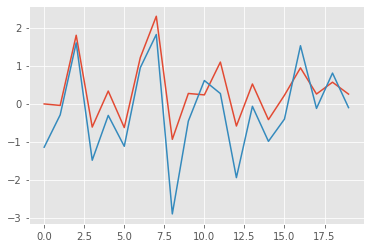

In [ ]:
from numpy import unravel_index

index_max = unravel_index(corr.argmax(), corr.shape)
X_i = A[:, index_max[0]]
X_j = A[:, index_max[1]]

for i in [X_i, X_j]:
    plt.plot(range(len(i)), i)


5. Очевидно, что на самом деле никакой взаимосвязи между этими переменными нет. Давайте в этом убедимся. Для этого подсчитайте и выведите значение корреляции между $X_i$ и $X_j$ на основе данных из матрицы $B$. Используйте функцию [`scipy.stats.pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) (аналогична `np.corrcoef` из numpy). Отобразите значения найденных переменных $X_i$ и $X_j$ из матрицы $B$ на графике. У Вас должна получиться очень маленькая (по абсолютному значению) корреляция.

In [ ]:
# from scipy.stats import pearsonr

# # YOUR CODE HERE
# corr_2 = np.zeros((5000, 5000))   # может я что то не правильно делаю, но этот код выполняется очень долго, но идейно вроде все правильно (мне лень ждать результата его выполнения)
# for i in range(5000):
#     for j in range(5000):
#         corr_2[i, j] = pearsonr(B[:, i], B[:, j])[0]
# print(corr_2)

## Формат результата

График значений найденных переменных $X_i$ и $X_j$ из матрицы $A$. Пример:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX04/result1_1_task_ex04.png" width="300">

График значений найденных переменных $X_i$ и $X_j$ из матрицы $B$. Пример:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX04/result2_1_task_ex04.png" width="300">

# Задание 2. Методы понижения размерности

Примените методы понижения размерности: PCA, t-SNE и UMAP к изображениям клеток крови из датасета BloodMNIST. Отобразите проекцию данных на двумерное пространство, так как это допускает наиболее простую визуализацию полученного результата (воспользуйтесь [`sns.scatterplot`](https://seaborn.pydata.org/generated/seaborn.scatterplot.html)).  Какой метод позволяет лучше разделить данные в пространстве? Опишите ваши наблюдения. 

Произведем загрузку данных:

In [ ]:
data_flag = 'bloodmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(dataset_without_pytorch, info['python_class'])

# load the data
bloodmnist = DataClass(split='train', download=download)
print(bloodmnist)

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×2

Доступ к данным идет посредством обращения к ключу `bloodmnist.imgs`, доступ к разметке классов через `bloodmnist.labels`

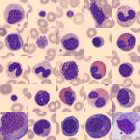

In [ ]:
x = bloodmnist.imgs / 255.
x = x.reshape(-1, 2352)
y = pd.Series(bloodmnist.labels.reshape(-1))
y = y.astype('int').map(dict(zip(range(0, 8), info['label'].values())))

 
bloodmnist.montage(length=5)

In [ ]:
print(x.shape)
print(x[0])

(11959, 2352)
[0.98039216 0.8745098  0.80784314 ... 1.         0.89411765 0.78823529]


In [ ]:
print(y.shape)
print(y)

(11959,)
0                                                 platelet
1        immature granulocytes(myelocytes, metamyelocyt...
2                                               neutrophil
3                                               neutrophil
4                                                 platelet
                               ...                        
11954                                           neutrophil
11955                                         erythroblast
11956                                           eosinophil
11957                                           neutrophil
11958                                           lymphocyte
Length: 11959, dtype: object


## PCA

(11959, 2)


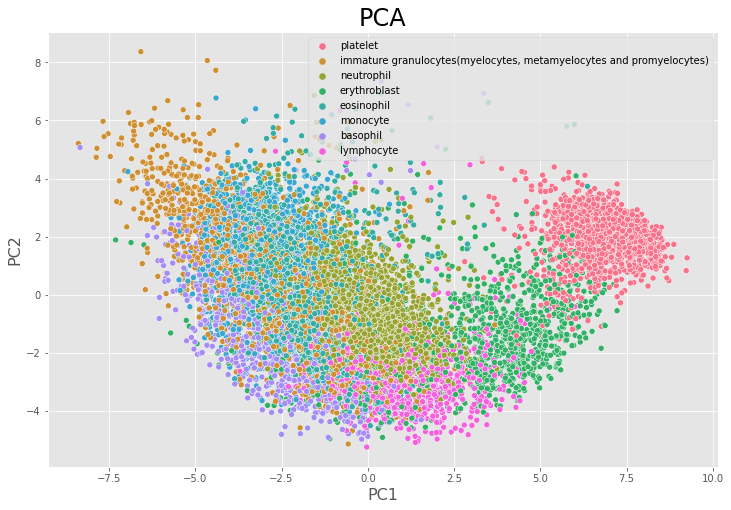

In [ ]:
## ENTER YOUR CODE HERE ##
pca_decomposer = PCA(n_components=2)
pca_decomposer.fit(x)
x_reduced = pca_decomposer.transform(x)

print(x_reduced.shape)

plt.figure(figsize=(12, 8))
plt.title('PCA', size=24)
plt.xlabel('PC1', size=16)
plt.ylabel('PC2', size=16)
sns.scatterplot(x=x_reduced[:, 0], y=x_reduced[:, 1], hue=y)

## t-SNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 11959 samples in 0.018s...
[t-SNE] Computed neighbors for 11959 samples in 2.299s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11959
[t-SNE] Computed conditional probabilities for sample 2000 / 11959
[t-SNE] Computed conditional probabilities for sample 3000 / 11959
[t-SNE] Computed conditional probabilities for sample 4000 / 11959
[t-SNE] Computed conditional probabilities for sample 5000 / 11959
[t-SNE] Computed conditional probabilities for sample 6000 / 11959
[t-SNE] Computed conditional probabilities for sample 7000 / 11959
[t-SNE] Computed conditional probabilities for sample 8000 / 11959
[t-SNE] Computed conditional probabilities for sample 9000 / 11959
[t-SNE] Computed conditional probabilities for sample 10000 / 11959
[t-SNE] Computed conditional probabilities for sample 11000 / 11959
[t-SNE] Computed conditional probabilities for sample 11959 / 11959
[t-SNE] Mean sigma: 0.716428
[t-SNE] Computed con

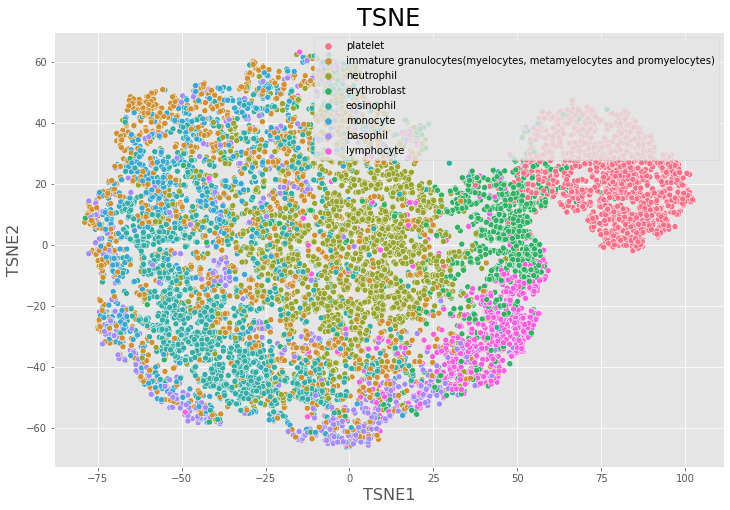

In [ ]:
## ENTER YOUR CODE HERE ##
x_reduced = PCA(n_components=6).fit_transform(x)
model = sklearn.manifold.TSNE(n_components=2, 
             init = x_reduced[:, 0:2], # often use as a reasonable approximation
             perplexity=40, # important parameter
             verbose=2,
             learning_rate='auto')

manifold = model.fit_transform(x_reduced)

print(manifold.shape)

plt.figure(figsize=(12, 8))
plt.title('TSNE', size=24)
plt.xlabel('TSNE1', size=16)
plt.ylabel('TSNE2', size=16)
sns.scatterplot(x=manifold[:, 0], y=manifold[:, 1], hue=y)

## UMAP

In [ ]:
from IPython.display import clear_output
!pip install umap-learn
!pip install --upgrade tbb
clear_output()

(11959, 2)


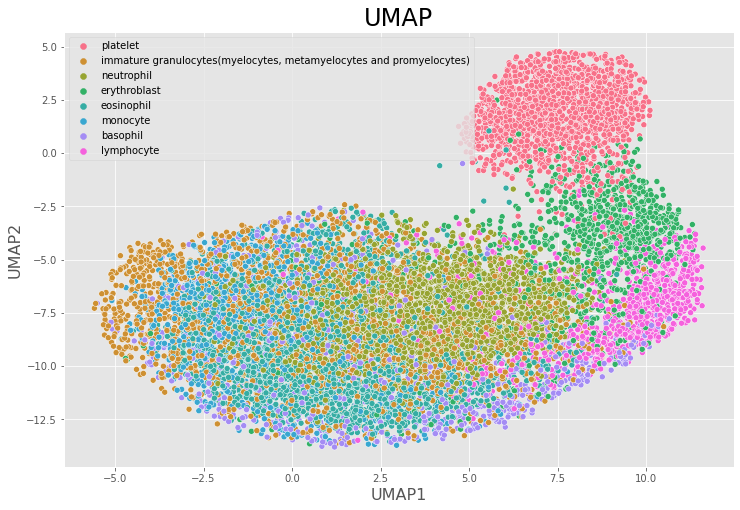

In [ ]:
## ENTER YOUR CODE HERE ##
from umap import UMAP
x_reduced = PCA(n_components=9).fit_transform(x)

model = UMAP(n_components=2, 
             min_dist=1, 
             n_neighbors=93,
             init=x_reduced[:, 0:2], 
             n_epochs=1000, 
             verbose=2)

umap = model.fit_transform(x_reduced)
clear_output()

print(umap.shape)

plt.figure(figsize=(12, 8))
plt.title('UMAP', size=24)
plt.xlabel('UMAP1', size=16)
plt.ylabel('UMAP2', size=16)
sns.scatterplot(x=umap[:, 0], y=umap[:, 1], hue=y)

Выводы: 

*Ваш текст тут*

## Формат результата

Пример графика для одного из пунктов задания:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX04/result_2_task_ex04.png" width="300">

# Задание 3. Feature selection и feature engineering

В этом задании используя датасет с [данными о здоровье плода](https://www.kaggle.com/andrewmvd/fetal-health-classification), сравните различные подходы к отбору признаков. Загрузим датасет:

In [ ]:
data = pd.read_csv("https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX04/fetal_health.csv")
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


Посмотрим на данные. Видно, что среди представленных признаков довольно много скоррелированных:

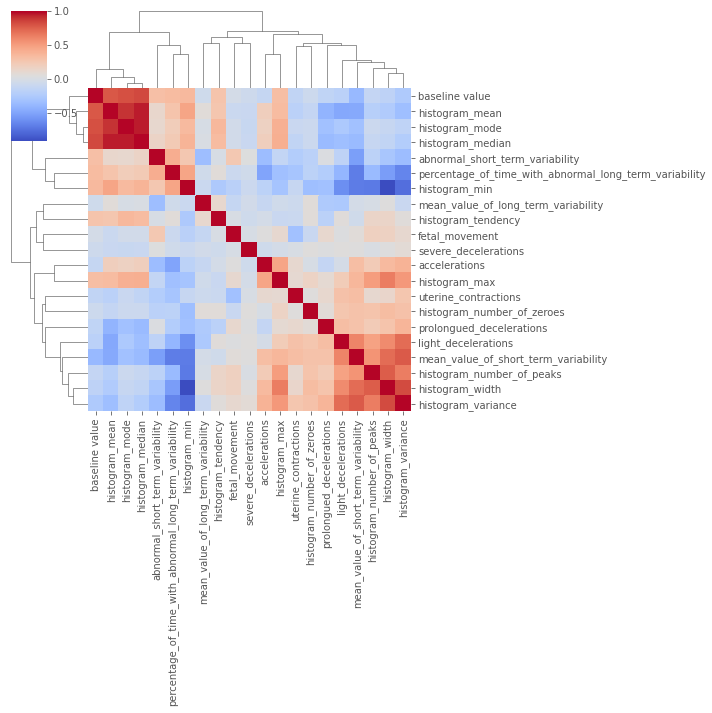

In [ ]:
x = data.drop('fetal_health', axis=1)
x = pd.DataFrame(StandardScaler().fit_transform(x), columns=x.columns, index= x.index)
y = data['fetal_health']

corr_matrix = x.corr(method='spearman')
res = sns.clustermap(corr_matrix, method='weighted', figsize=(10, 10), cmap='coolwarm')

Используя жадный отбор признаков, Add Del и PCA, отберите/сгенерируйте от 1 до 20 признаков и сравните на кросс-валидации `accuracy` для моделей `RandomForestClassifier(n_estimators=50, random_state=42)` из `sklearn.ensemble`, получающихся в процессе отбора/генерации признаков. Сравните полученные результаты с `accuracy` модели, обученной с использованием всех имеющихся признаков (на кросс-валидации с тем же количеством фолдов). Изобразите результаты в виде графика, опишите свои наблюдения.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler # а зачем, уже все отнормировано

## ENTER YOUR CODE HERE ##
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(f" x_train-{x_train.shape}\n x_test-{x_test.shape}\n y_train-{y_train.shape}\n y_test-{y_test.shape}")

 x_train-(1700, 21)
 x_test-(426, 21)
 y_train-(1700,)
 y_test-(426,)


In [ ]:
def data_graph(df): # выводит данные для построения графика acc
    acc = []
    for i in range(20):
        param = list(df['feature_idx'].iloc[i])
        model = RandomForestClassifier(n_estimators=50, random_state=42)
        model.fit(x_train.iloc[:, param], y_train)
        acc.append(model.score(x_test.iloc[:, param], y_test))
    return acc

In [ ]:
from sklearn.model_selection import KFold

def data_graph_kfold(df): # выводит данные для построения графика acc
    acc = []
    for i in range(20):
        param = list(df['feature_idx'].iloc[i])

        cv = KFold(n_splits=5, random_state=42, shuffle=True)
        model = RandomForestClassifier(n_estimators=50, random_state=42)
        scores = cross_val_score(model, x.iloc[:, param], y, scoring='accuracy', cv=cv, n_jobs=-1)

        acc.append(scores.mean())
    return acc

In [ ]:
# 1) жадный отбор признаков
from mlxtend.feature_selection import SequentialFeatureSelector 
from sklearn.ensemble import RandomForestClassifier

sfs = SequentialFeatureSelector(RandomForestClassifier(n_estimators=50, random_state=42),
                                k_features=20, # number of features to select
                                cv=5, # determines the cross-validation splitting strategy (5-fold cross validation)
                                scoring='accuracy')
sfs.fit(x_train, y_train)
df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

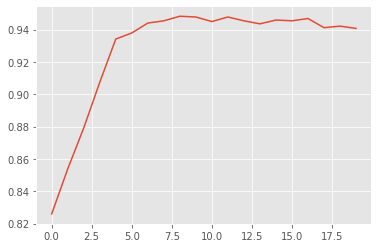

In [ ]:
gts = data_graph_kfold(df)
plt.plot(range(20), gts)

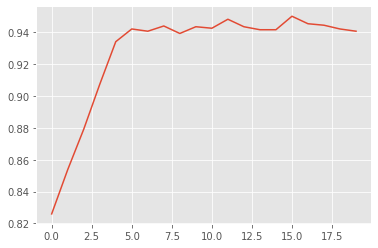

In [ ]:
# 2) Add Del
sffs = SequentialFeatureSelector(RandomForestClassifier(n_estimators=50, random_state=42),
                                k_features=20, # number of features to select
                                forward=True, # means that sffs will select the features.
                                floating=True, # means that sffs will select the features.
                                verbose=0, # means that no progress will be printed
                                cv=5, # determines the cross-validation splitting strategy (5-fold cross validation)
                                scoring='accuracy')
sffs.fit(x_train.values, y_train)
df = pd.DataFrame.from_dict(sffs.get_metric_dict()).T

add_del = data_graph_kfold(df)
plt.plot(range(20), add_del)

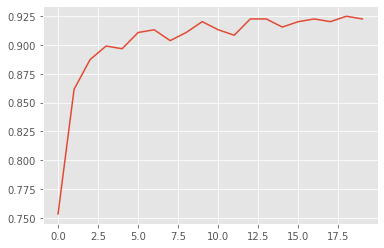

In [ ]:
# 3) PCA (https://habr.com/ru/company/ruvds/blog/488342/)
pca = PCA(n_components=20)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

pca_acc = []

for i in range(20):
    ind = range(i+1)
    x_train_pca[:, ind]
    
    rfc = RandomForestClassifier()
    rfc.fit(x_train_pca[:, ind], y_train)
    buf = rfc.score(x_test_pca[:, ind], y_test)

    pca_acc.append(buf)

# ind = range(0)
# x_train_pca[:, ind].shape

plt.plot(range(20), pca_acc)

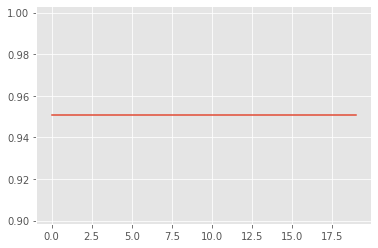

In [ ]:
# 4) без выделения компонент и понижения числа признаков
model = RandomForestClassifier()
model.fit(x_train, y_train)
acc_rfc = model.score(x_test, y_test)
rfc = []
for i in range(20):
    rfc.append(acc_rfc)

plt.plot(range(20), rfc)

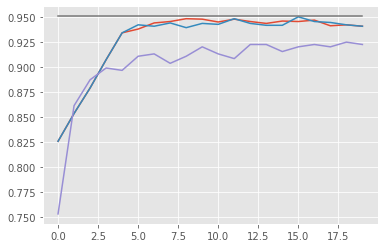

In [ ]:
plt.plot(range(20), gts, label='sfs') # 1
plt.plot(range(20), add_del, label='add_del') # 2
plt.plot(range(20), pca_acc, label='PCA') # 3
plt.plot(range(20), rfc, label='rfc') # 4

_Вывод:_

_Ваш текст тут._

## Формат результата

* Accuracy модели, обученной с использованием всех имеющихся признаков >0.9.

* Пример графика для одного из пунктов задания:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX04/result_3_task_ex04_fix.png" width="300">

# Задание 4. Использование понижения размерности для ускорения обучения

Рассмотрите набор данных TissueMNIST. В этом задании вам нужно сравнить производительность двух моделей: обученной с использованием всех доступных признаков и обученной на данных пониженной размерности. От вас требуется:

1. Посторить модель `RandomForestClassifier()` и обучить ее на тренировочной выборке, оценить `accuracy` модели на тестовой выборке и время, потраченное на обучение;
2. Построить модель PCA на тернировочных данных и определите число главных компонент, объясняющих 90% дисперсии (или используйте любой другой способ выбора оптимального числа главных компонент, разбиравшийся на лекции);
3. Спроецировать данные тестовой выборки на главные компоненты, полученной модели PCA;
4. Построить модель `RandomForestClassifier()` и обучить ее на данных пониженной размерности, оценить `accuracy` модели на тестовой выборке и время, потраченное на обучение;
5. Опишите ваши наблюдения, сделайте выводы.

_Note: Обратите внимание, что параметр `n_components` при создании экземпляра класса `PCA` может принимать не только целочисленные значения (непосредственно количество компонент в "штуках"), но и вещественные на интервале $(0, 1)$. Ознакомьтесь с описанием класса [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) и определите как можно использовать вещественное `n_components` для решения задачи._

In [ ]:
data_flag = 'tissuemnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(dataset_without_pytorch, info['python_class'])

# load the data
tissuemnist = DataClass(split='test', download=download)
print(tissuemnist)

  0%|          | 0/124962739 [00:00<?, ?it/s]

Dataset TissueMNIST (tissuemnist)
    Number of datapoints: 47280
    Root location: /root/.medmnist
    Split: test
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'Collecting Duct, Connecting Tubule', '1': 'Distal Convoluted Tubule', '2': 'Glomerular endothelial cells', '3': 'Interstitial endothelial cells', '4': 'Leukocytes', '5': 'Podocytes', '6': 'Proximal Tubule Segments', '7': 'Thick Ascending Limb'}
    Number of samples: {'train': 165466, 'val': 23640, 'test': 47280}
    Description: We use the BBBC051, available from the Broad Bioimage Benchmark Collection. The dataset contains 236,386 human kidney cortex cells, segmented from 3 reference tissue specimens and organized into 8 categories. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. Each gray-scale image is 32×32×7 pixels, where 7 denotes 7 slices. We take maximum values across the slices and resize them into 28×28 gray-scale images.
    License: CC BY 4

In [ ]:
x = tissuemnist.imgs / 255.
x = x.reshape(-1, 784)
y = tissuemnist.labels
 
tissuemnist.montage(length=5)

x_train, x_test, y_train,y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
x_train.shape

(37824, 784)

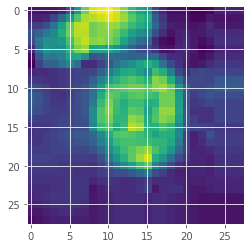

In [ ]:
plt.imshow(tissuemnist.imgs[1])

In [ ]:
# Пункт 1

import time

rng = np.random.RandomState(42)
rf = RandomForestClassifier(n_estimators=200, random_state=rng)

## ENTER YOUR CODE HERE ##
start = time.time() # начало отсчета работы алгоритма
rf.fit(x_train, y_train)
end = time.time() # конец работы алгоритма
y_pred = rf.predict(x_test)

acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

time_taken = end - start
print('Time taken:', time_taken)

Accuracy: 0.5329949238578681
Time taken: 182.5619921684265


In [ ]:
# Пункт 2
## ENTER YOUR CODE HERE ##

pca = PCA(n_components=0.9)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)

n_components = pca.n_components_
print('Number of principal components:', n_components)

print("x_train - ", x_train.shape)
print("x_train_pca - ", x_train_pca.shape)

Number of principal components: 58
x_train -  (37824, 784)
x_train_pca -  (37824, 58)


In [ ]:
# Пункт 3
## ENTER YOUR CODE HERE ##

x_test_pca = pca.transform(x_test)
print("x_test - ", x_test.shape)
print("x_test_pca - ", x_test_pca.shape)

x_test -  (9456, 784)
x_test_pca -  (9456, 58)


In [ ]:
# Пункт 4
clf = RandomForestClassifier(n_estimators=200, random_state=rng)
start = time.time() # начало отсчета работы алгоритма
clf.fit(x_train_pca, y_train)
end = time.time() # конец работы алгоритма
y_pred = clf.predict(x_test_pca)
accuracy = accuracy_score(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

time_taken = end - start
print('Time taken:', time_taken)

Accuracy: 0.507085448392555
Time taken: 89.43465399742126


_Вывод:_

_Ваш текст тут_


## Формат результата

Получить значения точности (`accuracy`) и времени обучения `RandomForestClassifier()` на обычных данных и пониженной размерности